In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, projectUMAP, fitGMM

from auctions.webutils import *

from scipy.stats import loguniform
import copy

import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Magma256
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

output_notebook()


Loading BokehJS ...

In [28]:
# Question 1: What is the NashConv of each run?

checkpoint = EquilibriumSolverRunCheckpoint.objects.last()

In [29]:
policy = pickle.loads(checkpoint.policy)

In [30]:
policy[0]['ppo_network']['critic.2.weight'].shape

torch.Size([200, 200])

In [56]:
all_eq_pks = EquilibriumSolverRunCheckpoint.objects.filter(equilibrium_solver_run__experiment__name='confused_national_wide_test_with_gpu', t__gte=10_000).values_list('pk', flat=True)

In [130]:
np.random.choice(all_eq_pks, size=1, replace=False)

array([5520])

In [132]:
checkpoints = EquilibriumSolverRunCheckpoint.objects.filter(pk__in=pks)

In [134]:
EquilibriumSolverRunCheckpoint.objects.get(pk__in=[5520])

<EquilibriumSolverRunCheckpoint: confused_national-nov18ppo_potential_pricing-102 (confused_national_wide_test_with_gpu) Iteration 2560000>

In [133]:
checkpoints

<QuerySet [<EquilibriumSolverRunCheckpoint: confused_national-aug11ppo_potential_length-100 (confused_national_wide_test_with_gpu) Iteration 2560000>, <EquilibriumSolverRunCheckpoint: confused_national-nov18ppo_potential_pricing-102 (confused_national_wide_test_with_gpu) Iteration 2560000>, <EquilibriumSolverRunCheckpoint: confused_national_with_undersell-nov18ppo_potential_revenue-101 (confused_national_wide_test_with_gpu) Iteration 7680000>]>

In [276]:
pks = np.array([5347, 5592, 5520])
# pks = np.array([5520])


In [ ]:
# from open_spiel.python.examples.ubc_dispatch import *

# for checkpoint in checkpoints:
#     experiment_name = checkpoint.equilibrium_solver_run.experiment.name
#     run_name = checkpoint.equilibrium_solver_run.name
#     t = checkpoint.t
#     configs = 'nov22'
#     for br_player in range(2):
#         dispatch_br_database(experiment_name, run_name, t, br_player, configs, submit=True, mem=32, overrides='--total_timesteps 1_000_000')

In [269]:
### CONFIG GENERATOR

base = yaml.safe_load(open('configs/nov21/ppo_default.yml'))

In [273]:
N_CONFIGS = 100

configs = []


# TODO: NUM_ANNEALING_UPDATES

for _ in range(N_CONFIGS):
    x = copy.deepcopy(base)
    
    x['steps_per_batch'] = int(np.random.choice([64, 128, 256, 512]))
    x['num_minibatches'] = int(np.random.choice([2, 4, 8]))
    x['update_epochs'] = int(np.random.choice([2, 4, 8]))
    x['learning_rate'] = float(np.random.choice([1e-5, 1e-4, 1-3, 3e-5, 3e-4, 3e-3]))
    x['gae'] = bool(np.random.choice([True, False]))
    x['gamma'] = float(np.random.uniform(0.8, 1.))
    x['anneal_lr'] = bool(np.random.choice([True, False]))
    x['gae_lambda'] = float(np.random.uniform(0.8, 1.))
    x['clip_coef'] = float(loguniform.rvs(0.001, .07, size=1)[0])
    x['clip_vloss'] = bool(np.random.choice([True, False]))
    x['entropy_coef'] = float(loguniform.rvs(0.001, .1, size=1)[0])
    x['value_coef'] = float(loguniform.rvs(0.1, 1.5, size=1)[0])
    x['num_envs'] = int(np.random.choice([4, 8, 16]))
    
    agent_kwargs = dict()
    agent_kwargs['actor_activation'] = str(np.random.choice(['relu', 'tanh']))
    agent_kwargs['critic_activation'] = str(np.random.choice(['relu', 'tanh']))
    agent_kwargs['actor_hidden_sizes'] = np.random.choice(np.array([
        [64, 64], [128, 128], [256, 256], [64, 64, 64], [128, 128, 128], [256, 256, 256],
    ], dtype=object))
    agent_kwargs['critic_hidden_sizes'] = np.random.choice(np.array([
        [64, 64], [128, 128], [256, 256], [64, 64, 64], [128, 128, 128], [256, 256, 256],
    ], dtype=object))
    x['agent_fn_kwargs'] = agent_kwargs
    
    configs.append(x)

In [275]:
for i, config in enumerate(configs):
    yaml.dump(config, open(f'configs/nov22/ppo_{i}.yml', 'w'))
    

In [346]:
pks = np.array([5347, 5592, 5520])


In [347]:
# Load all of the BRs for a given config
dfs = []
for pk in pks:
    checkpoint = EquilibriumSolverRunCheckpoint.objects.get(pk=pk)
    df = parse_run(checkpoint.equilibrium_solver_run)
    # Remove bad checkopints
    df = df.query(f't == {df["t"].value_counts().idxmax()}')
    dfs.append(df)

In [348]:
master_df = pd.concat((*dfs,))

In [349]:
print(master_df['name'].nunique())
master_df['freq'] = master_df['name'].map(master_df['name'].value_counts())
master_df = master_df.query('freq >= 4')
del master_df['freq']
master_df['name'].nunique()

191


190

In [350]:
sub_frames = []
for _, sub_df in master_df.query('not name.isnull() and player == br_player', engine='python').groupby(['model', 't']):
    sub_df = sub_df[['name', 'MaxPositiveRegret', 'Regret']].copy()
    sub_df['Δ to Best Known Response'] = sub_df['Regret'] - sub_df['MaxPositiveRegret']
    sub_df = sub_df[['name', 'Δ to Best Known Response']]
    sub_df['name'] = sub_df['name'].str.replace('_', ' ').str.strip()
    sub_frames.append(sub_df)
distance_frame = pd.concat(sub_frames)


In [351]:
# Only show those near the current defaults
target_mean = distance_frame.query('name == "nov21/ppo default"')['Δ to Best Known Response'].mean()
fudge = 200
print(target_mean)
distance_frame = distance_frame.groupby('name').filter(lambda x: x['Δ to Best Known Response'].mean() >= target_mean - 500)

-281.33012712166965


In [352]:
distance_frame['median'] = distance_frame['name'].map(distance_frame.groupby('name')['Δ to Best Known Response'].median().sort_values(ascending=False))
distance_frame = distance_frame.sort_values('median')
del distance_frame['median']

[Text(0, 0, 'nov21/ppo 84'),
 Text(1, 0, 'nov21/ppo 0'),
 Text(2, 0, 'nov21/ppo 18'),
 Text(3, 0, 'nov22/ppo 82'),
 Text(4, 0, 'nov22/ppo 28'),
 Text(5, 0, 'nov22/ppo 49'),
 Text(6, 0, 'nov21/ppo 75'),
 Text(7, 0, 'nov22/ppo 80'),
 Text(8, 0, 'nov22/ppo 89'),
 Text(9, 0, 'nov21/ppo 38'),
 Text(10, 0, 'nov21/ppo 96'),
 Text(11, 0, 'nov22/ppo 27'),
 Text(12, 0, 'nov22/ppo 53'),
 Text(13, 0, 'nov22/ppo 43'),
 Text(14, 0, 'nov22/ppo 20'),
 Text(15, 0, 'nov21/ppo 42'),
 Text(16, 0, 'nov21/ppo 93'),
 Text(17, 0, 'nov21/ppo 24'),
 Text(18, 0, 'nov21/ppo 53'),
 Text(19, 0, 'nov22/ppo 25'),
 Text(20, 0, 'nov21/ppo 61'),
 Text(21, 0, 'nov22/ppo 23'),
 Text(22, 0, 'nov22/ppo 32'),
 Text(23, 0, 'nov21/ppo 52'),
 Text(24, 0, 'nov22/ppo 90'),
 Text(25, 0, 'nov22/ppo 93'),
 Text(26, 0, 'nov21/ppo 28'),
 Text(27, 0, 'nov22/ppo 79'),
 Text(28, 0, 'nov21/ppo 11'),
 Text(29, 0, 'nov21/ppo 7'),
 Text(30, 0, 'nov21/ppo 10'),
 Text(31, 0, 'nov21/ppo 76'),
 Text(32, 0, 'nov21/ppo 60'),
 Text(33, 0, 'nov22/pp

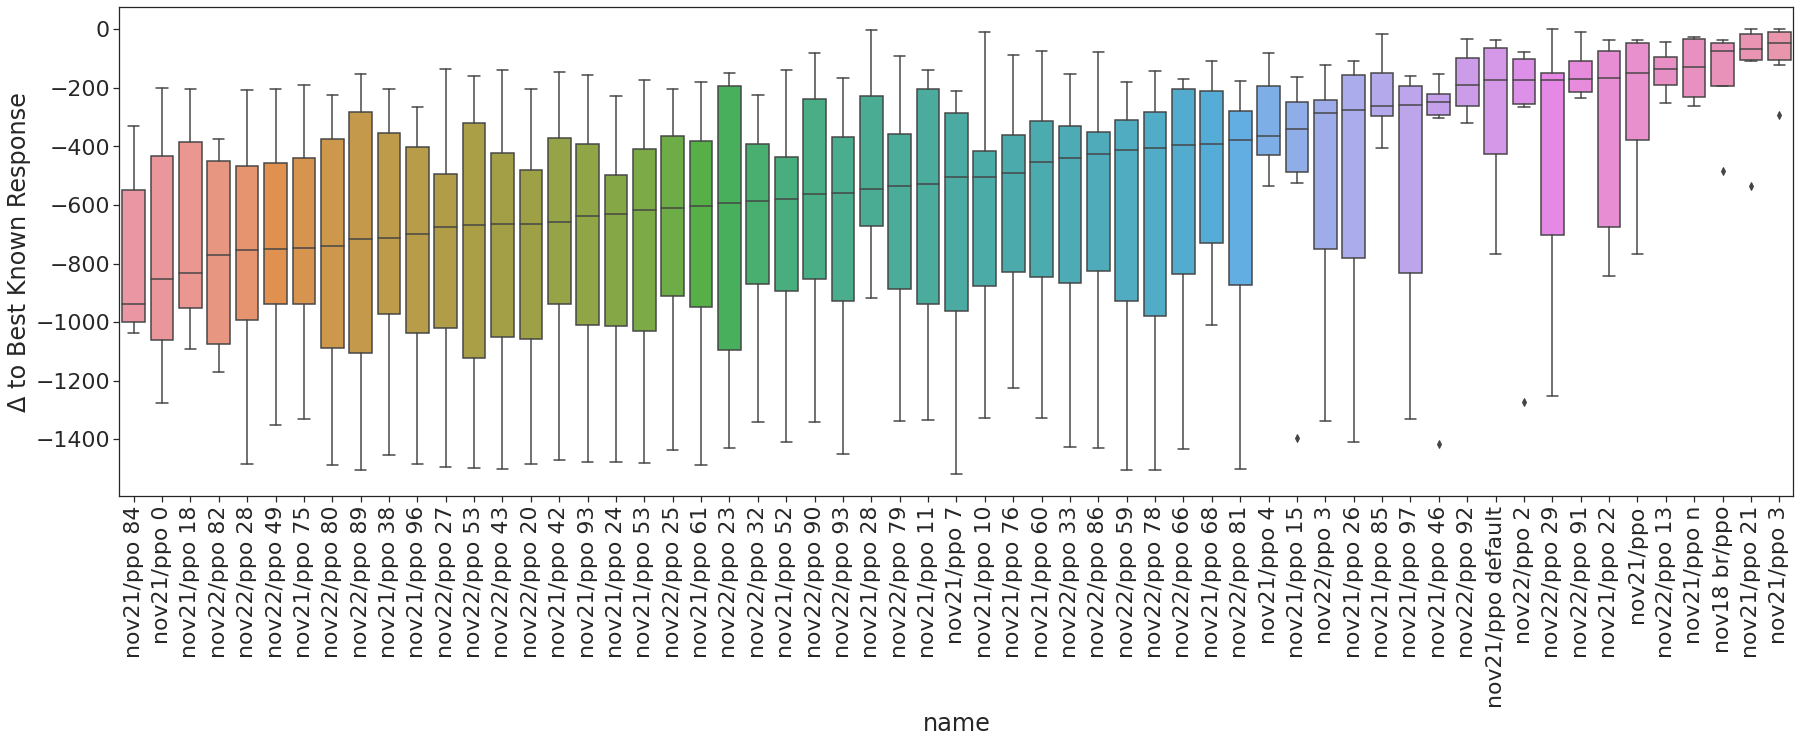

In [353]:
sns.set_theme(style="ticks", palette="pastel", font_scale=2)

# Draw a nested boxplot 
fig = plt.figure(figsize=(30, 9))
# sns.ecdfplot(hue="config", x="Δ to Best Known Response", data=distance_frame.sort_values('config'))
ax = sns.boxplot(x="name", y="Δ to Best Known Response", data=distance_frame)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [4]:
checkpoint = EquilibriumSolverRunCheckpoint.objects.get(equilibrium_solver_run__name='confused_national-nov23ppo_3_neg_revenue-101')
df = parse_run(checkpoint.equilibrium_solver_run)


In [7]:
df.query('name != "straightforward"')

,t,name,reward,br_player,player,median_length,Baseline,Regret,PositiveRegret,MaxPositiveRegret,ApproxNashConv,num_players,model,game
1,2499968,nov23br/ppo_3,4643.864873,0,0,NaN,4649.953152,-6.088279,0.0,0.0,0.0,2,confused_national-nov23ppo_3_neg_revenue-101,confused_national.json
2,2499968,None,4649.953152,None,0,5.0,4649.953152,0.000000,0.0,0.0,0.0,2,confused_national-nov23ppo_3_neg_revenue-101,confused_national.json
4,2499968,nov23br/ppo_3,5443.463836,1,1,NaN,5454.410489,-10.946653,0.0,0.0,0.0,2,confused_national-nov23ppo_3_neg_revenue-101,confused_national.json
5,2499968,None,5454.410489,None,1,5.0,5454.410489,0.000000,0.0,0.0,0.0,2,confused_national-nov23ppo_3_neg_revenue-101,confused_national.json
